<a href="https://colab.research.google.com/github/skumarudel/DS_Physicists/blob/master/Lecture3-Statistics/HypothesisTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import random
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Files required for analysis

In [2]:
path_to_data = 'https://raw.githubusercontent.com/skumarudel/DS_Physicists/master/Lecture3-Statistics/datafiles/'

WEB_PAGE_DATA_CSV = path_to_data + 'web_page_data.csv'
FOUR_SESSIONS_CSV =  path_to_data + 'four_sessions.csv'
CLICK_RATE_CSV = path_to_data + 'click_rates.csv'
IMANISHI_CSV = path_to_data + 'imanishi_data.csv'

In [3]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 100 * session_times.Time


In [23]:
session_times.head()



,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0
4,Page A,67.0


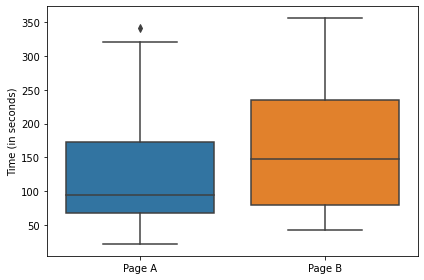

In [7]:
ax = sns.boxplot(x="Page", y="Time", data=session_times)
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()


In [19]:
df_time = session_times.groupby(['Page']).mean().reset_index().rename(columns={'Time': 'Mean_Time'})
df_time

,Page,Mean_Time
0,Page A,126.333333
1,Page B,162.000000


In [20]:
df_time.Mean_Time.iloc[1] - df_time.Mean_Time.iloc[0]

35.66666666666667